# Gas Storage

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

import sys
if '../..' not in sys.path:
    sys.path.append('../..')
    
from rivapy.instruments.gasstorage_specification import GasStorageSpecification
from rivapy.pricing.gas_storage_pricer import PricingParameter, pricing_lsmc

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Introduction to Gas Storage Valuation

Least Squares Monte Carlo valuation method to adjust storage trading decisions to price conditions given a seasonal demand.
The task is to find the optimal operation (injection and withdrawal) of the storage, depending on current and expected gas prices, based on predictable price movements (seasonality) and unpredictable price fluctuations
(volatility).

[1] Gas Storage Valuation Using a Monte Carlo Method (Boogert and De Jong)

[2] Valuing American Options by Simulation: A Simple Least-Squares Approach(Longstaff and Schwartz)

The storage contract from the perspective of the contract holder

signed at $t=0$ and settled at $t=T+1$

The contract allows the holder to take a desired action at any discrete date $t = 1, ..., T$ after the spot price $S(t)$ is revealed.
Every day the holder of a storage contract can choose to inject gas, do nothing, or withdraw gas, within certain volumetric limitations.

An injection at day $t$ is a positive volume change $\Delta v(t)$ and represents costs, while a withdrawal is a negative volume change $\Delta v(t)$ and represents profits. Note that at time $t = 0$ the holder cannot take an action, and $\Delta v(0) = 0$.

We denote the (accumulated) volume in storage at the start of day $t$ by $v(t)$ and with $\Delta v(t) = v(t+1) - v(t)$, the volume at day $t$ is 
$$v(t) = v(0) + \sum_{i=1}^t \Delta v(i-1) $$

The payoff at day $t=0, ..., T$ is 
$$ h(S(t), \Delta v(t)) = \begin{cases}
-c(S(t)) \Delta v(t)  &\text{inject at day } t \newline
0  &\text{do nothing at day } t \newline
-p(S(t)) \Delta v(t)  &\text{withdraw at day } t
\end{cases} $$

where $c(S(t))$ and $p(S(t))$ represent the cost of injection and profit of withdrawal, respectively.

$$ c(S(t)) = (1+a_1)S(t) + b_1 \ge 0$$
$$ p(S(t)) = (1-a_2)S(t) - b_2 \ge 0$$

with transaction costs $a$ and bid-ask spreads $b$.

We denote the interest rate by $\delta$.
At settlement the holder receives a potential penalty, denoted by $q(S(T + 1),v(T+ 1))$.

The volume in storage must stay between a minimum level and a maximum level for $t=1,...,T+1$:
$$0 \le v^{min}(t) \le v(t) \le v^{max}(t)$$ 

The injection and withdrawal is limited per day:
$$ i^{min}(t, v(t)) \le \Delta v(t) \le i^{max}(t, v(t))$$

The value of a storage contract is the expected value of the accumulated future payoffs $h(S(t), Av(t))$ 
under the most optimal strategy $\pi$.

In [4]:
def create_contract_dates(startdate: dt.datetime, enddate: dt.datetime, datestep:dt.timedelta)->list:
    dates=[startdate]
    while dates[-1] <= enddate-datestep:
        dates.append(dates[-1]+datestep)

    #dates=[startdate]*n #nb_timesteps 
    #for i in range(1,n):
    #    dates[i] = dates[i-1] + dateStep

    return dates

In [5]:
class GeometricBrownianMotionSimulator:
    """Simulate a 1D Geometric Brownian Motion for a datetime timegrid"""

    def __init__(self, timegrid: list, mu: float, sigma: float):

        self.timegrid = timegrid
        self.mu = mu
        self.sigma = sigma

    def create_gbm(self, X0: float) -> np.array:
        dtt = []
        for i in range(len(self.timegrid)-1):
            dti = self.timegrid[i+1] - self.timegrid[i]
            dtt.append(dti.days/365.0)
        dt = np.array(dtt)
        rnd = np.random.normal(size=(len(self.timegrid)-1))
        Y = np.exp((self.mu - self.sigma**2 / 2) * dt + self.sigma * np.sqrt(dt) * rnd)
        R = X0 * np.cumprod(Y) 
        return np.insert(R, 0, X0) #add start value X0

In [6]:
## Setting the parameters
nomination = 1 #daily nomination
num_sims = 1_000 #number of independent price paths simulated
S0 = 1.0 #starting value
sigma = 0.1#00945
mu = 0.2

n_vol_levels = 11 #101
min_level = 0.0
storage_capacity = 10.0 #1_000
start_level = 0.0 #100_000
end_level = 0.0 #100_000
max_withdrawal = -1.0 #-7500
max_injection = 1.0 #2500

startdate = dt.datetime.fromisoformat('2021-01-01')
enddate = dt.datetime.fromisoformat('2021-12-31')
dateStep = dt.timedelta(days=nomination)
contractdates = create_contract_dates(startdate, enddate, dateStep)
#fwd_times = [(date - contractdates)/n for date in contractDates]

In [7]:
# Simulate M independent price paths S^b(1), S^b(T+1) for b = 1...M starting at S(0)
gbm_sim = GeometricBrownianMotionSimulator(contractdates, mu, sigma)
gbm = np.empty((len(contractdates), num_sims))
np.random.seed(1)
for i in range(num_sims):
    gbm[:,i] = gbm_sim.create_gbm(S0) 

In [8]:
params = PricingParameter(n_time_steps = 0, n_actions = 0, n_vol_levels = n_vol_levels)#, regression = _PolynomialRegressionFunction)
store = GasStorageSpecification(contractdates, storage_capacity, max_withdrawal, 
                                max_injection, end_level=end_level, 
                                min_level=min_level, start_level=start_level)  
price, vol_levels = pricing_lsmc(store, params, gbm, num_sims)#, _penalty_func)


In [13]:
print(price)

2.175630212705706


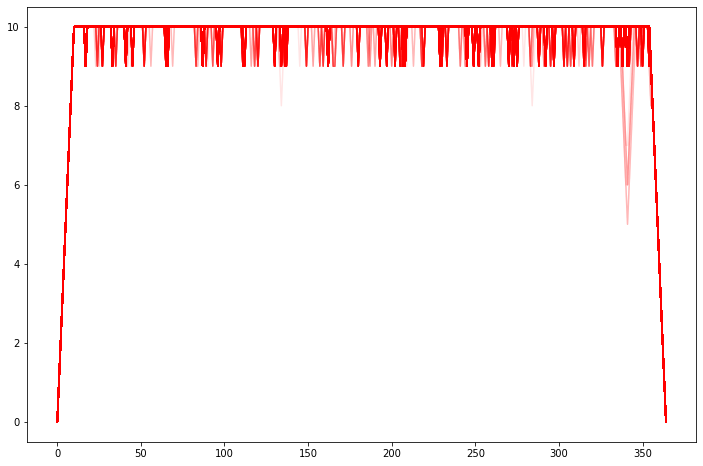

In [9]:
plt.figure(figsize=(12,8))
plt.plot(vol_levels,'-r', alpha=0.1)#[:,20])
plt.show()

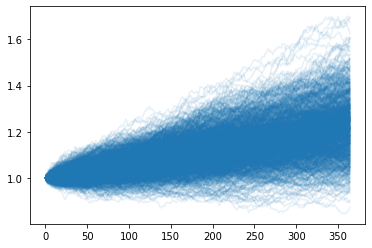

In [12]:
plt.figure()
for i in range(num_sims):
    plt.plot(gbm[:,i], 'tab:blue', alpha=0.1)
plt.show()